## More on PyMC

### Model Context

In PyMC, we typically handle all the variables we want in our model within the context of the `Model` object.

In [1]:
import pymc as pm
import pytensor
import numpy as np
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
# %config InlineBackend.figure_format = 'retina'
# the proper way to init the value is to use initval paramter
# The test_value is just for debug
# reference is at https://pytensor.readthedocs.io/en/latest/tutorial/debug_faq.html#using-test-values
# and https://github.com/pymc-devs/pymc/issues/562#issuecomment-932146862
# You can use pytensor.config.compute_test_value = 'warn'  to debug
with pm.Model() as model:
    parameter = pm.Exponential("poisson_param", 1.0, initval=rng.exponential(1))
    data_generator = pm.Poisson("data_generator", parameter)

Recall:

The **Exponential distribution** with rate parameter $\lambda$ is given by its probability density function:

$
f(x \mid \lambda) = \lambda \, e^{-\lambda x}, \quad \text{for } x \ge 0.
$

The **Poisson distribution** with rate parameter $\lambda$ has its probability mass function:

$
P(X = k) = \frac{\lambda^k e^{-\lambda}}{k!}, 
\quad k = 0, 1, 2, \dots
$

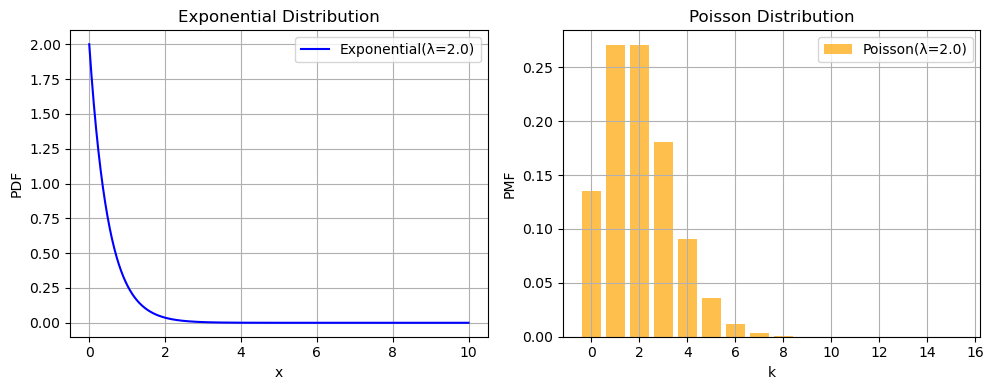

In [2]:
# easy implementation from scratch

import numpy as np
import matplotlib.pyplot as plt
import math

def exponential_pdf(x, lam):
    """Probability density function (pdf) for the exponential distribution."""
    return lam * np.exp(-lam * x)

def poisson_pmf(k, lam):
    """Probability mass function (pmf) for the Poisson distribution."""
    return (lam ** k) * np.exp(-lam) / math.factorial(k)

# --- Parameters ---
lam = 2.0  # Rate parameter
x_max = 10  # Range for exponential distribution plot
n_points = 1000  # Number of points for continuous plot

# --- Prepare Exponential Data ---
x_vals = np.linspace(0, x_max, n_points)
exp_vals = exponential_pdf(x_vals, lam)

# --- Prepare Poisson Data ---
# We'll plot Poisson probabilities up to k = 15 for illustration
k_vals = np.arange(0, 16)
poisson_vals = [poisson_pmf(k, lam) for k in k_vals]

# --- Plotting ---
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Plot the Exponential distribution (left subplot)
axes[0].plot(x_vals, exp_vals, color='blue', label=f'Exponential(λ={lam})')
axes[0].set_title('Exponential Distribution')
axes[0].set_xlabel('x')
axes[0].set_ylabel('PDF')
axes[0].grid(True)
axes[0].legend()

# Plot the Poisson distribution (right subplot)
axes[1].bar(k_vals, poisson_vals, color='orange', alpha=0.7, label=f'Poisson(λ={lam})')
axes[1].set_title('Poisson Distribution')
axes[1].set_xlabel('k')
axes[1].set_ylabel('PMF')
axes[1].grid(True)
axes[1].legend()

plt.tight_layout()
plt.show()


This is an extra layer of convenience compared to PyMC. Any variables created within a given `Model`'s context will be automatically assigned to that model. If you try to define a variable outside of the context of a model, you will get an error.

We can continue to work within the context of the same model by using `with` with the name of the model object that we have already created.

In [3]:
with model:
    data_plus_one = data_generator + 1

Each variable assigned to a model will be defined with its own name, the first string parameter (we will cover this further in the variables section). To create a different model object with the same name as one we have used previously, we need only run the first block of code again.

In [4]:
with pm.Model() as model_exp:
    theta = pm.Exponential("theta", 2.0)
    data_generator = pm.Poisson("data_generator", theta)

We can also define an entirely separate model. Note that we are free to name our models whatever we like, so if we do not want to overwrite an old model we need only make another.

In [5]:
with pm.Model() as ab_testing:
    p_A = pm.Uniform("P(A)", 0, 1)
    p_B = pm.Uniform("P(B)", 0, 1)

You probably noticed that PyMC will often give you notifications about transformations when you add variables to your model. These transformations are done internally by PyMC to modify the space that the variable is sampled in (when we get to actually sampling the model). This is an internal feature which helps with the convergence of our samples to the posterior distribution and serves to improve the results.

### PyMC Variables

All PyMC variables have an initial value, if you didn't distinct the paramater `initval`, PyMC will automatically initialize it for you after. 

Using the same variables from before:

In [6]:
#leave it to automatically init
with pm.Model() as model:
    parameter = pm.Exponential("poisson_param", 1.0)
    data_generator = pm.Poisson("data_generator", parameter)

In [7]:
for k,v in model.initial_point().items():
    print(f"{k} initval is {v}")

poisson_param_log__ initval is 0.0
data_generator initval is 1


In [10]:
#leave it to automatically init
with pm.Model() as model:
    parameter = pm.Exponential("poisson_param", 1.0,initval=rng.exponential(1))
    data_generator = pm.Poisson("data_generator", parameter,initval=rng.poisson(10))

In [11]:
for k,v in model.initial_point().items():
    print(f"{k} initval is {v}")

poisson_param_log__ initval is 0.8238773146158861
data_generator initval is 12


The `initval` parameter is used only for the model, as the starting point for sampling if no other start is specified. It will not change as a result of sampling. 

In [12]:
with pm.Model() as model:
    parameter = pm.Exponential("poisson_param", 1.0, initval=0.5)


model.initial_point()

{'poisson_param_log__': array(-0.69314718)}

This can be helpful (and be also helpful to debug, as the PyTensor document reference said above) if you are using a more unstable prior that may require a better starting point.

PyMC is concerned with two types of programming variables: stochastic and deterministic.

*  *stochastic variables* are variables that are not deterministic, i.e., even if you knew all the values of the variables' parameters and components, it would still be random. Included in this category are instances of classes `Poisson`, `DiscreteUniform`, and `Exponential`.

*  *deterministic variables* are variables that are not random if the variables' parameters and components were known. This might be confusing at first: a quick mental check is *if I knew all of variable `foo`'s component variables, I could determine what `foo`'s value is.* 

We will detail each below.

#### Initializing Stochastic variables

Initializing a stochastic, or random, variable requires a `name` argument, plus additional parameters that are class specific. For example:

`some_variable = pm.DiscreteUniform("discrete_uni_var", 0, 4)`

where 0, 4 are the `DiscreteUniform`-specific lower and upper bound on the random variable. The [PyMC docs](https://docs.pymc.io/en/stable/api.html) contain the specific parameters for stochastic variables.

The `name` attribute is used to retrieve the posterior distribution later in the analysis, so it is best to use a descriptive name. 

For multivariable problems, rather than creating a Python array of stochastic variables, addressing the `shape` keyword in the call to a stochastic variable creates multivariate array of (independent) stochastic variables. The array behaves like a NumPy array when used like one, and references to its `initval` attribute return NumPy arrays.  

The `shape` argument also solves the annoying case where you may have many variables $\beta_i, \; i = 1,...,N$ you wish to model. Instead of creating arbitrary names and variables for each one, like:

    beta_1 = pm.Uniform("beta_1", 0, 1)
    beta_2 = pm.Uniform("beta_2", 0, 1)
    ...

we can instead wrap them into a single variable:

    betas = pm.Uniform("betas", 0, 1, shape=N)

#### Deterministic variables

We can create a deterministic variable similarly to how we create a stochastic variable. We simply call up the `Deterministic` class in PyMC and pass in the function that we desire

    deterministic_variable = pm.Deterministic("deterministic variable", some_function_of_variables)

For all purposes, we can treat the object `some_deterministic_var` as a variable and not a Python function. 

Calling [`pymc.Deterministic`](https://www.pymc.io/projects/docs/en/latest/api/generated/pymc.Deterministic.html?highlight=Deterministic) is the most obvious way, but not the only way, to create deterministic variables. Elementary operations, like addition, exponentials etc. implicitly create deterministic variables. For example, the following returns a deterministic variable:

In [16]:
with pm.Model() as model:
    lambda_1 = pm.Exponential("lambda_1", 1.0,initval=0.5)
    lambda_2 = pm.Exponential("lambda_2", 1.0,initval=0.5)
    tau = pm.DiscreteUniform("tau", lower=0, upper=10)

new_deterministic_variable = lambda_1 + lambda_2

If we want a `deterministic` variable to actually be tracked by our sampling, however, we need to define it explicitly as a named `deterministic` variable with the constructor.

The use of the `deterministic` variable was seen in the text-message example.  Recall the model for $\lambda$ looked like: 

$$
\lambda = 
\begin{cases}\lambda_1  & \text{if } t \lt \tau \cr
\lambda_2 & \text{if } t \ge \tau
\end{cases}
$$



In [23]:
import numpy as np
n_data_points = 5  
idx = np.arange(n_data_points)
with model:
    lambda_ = pm.math.switch(tau >= idx, lambda_1, lambda_2)

Clearly, if $\tau, \lambda_1$ and $\lambda_2$ are known, then $\lambda$ is known completely, hence it is a deterministic variable. We use the `switch` function here to change from $\lambda_1$ to $\lambda_2$ at the appropriate time. This function is directly from the `pytensor.tensor.basic` package, which we will discuss in the next section.

Inside a `deterministic` variable, the stochastic variables passed in behave like scalars or NumPy arrays (if multivariable). We can do whatever we want with them as long as the dimensions match up in our calculations.

For example, running the following (off course you NEED to define model session firstly):

    def subtract(x, y):
        return x - y
    with model:
        stochastic_1 = pm.Uniform("U_1", 0, 1)
        stochastic_2 = pm.Uniform("U_2", 0, 1)

        det_1 = pm.Deterministic("Delta", subtract(stochastic_1, stochastic_2))
    
Is perfectly valid PyMC code. Saying that our expressions behave like NumPy arrays is not exactly honest here, however. The main catch is that the expression that we are making *must* be compatible with `pytensor` tensors, which we will cover in the next section. Feel free to define whatever functions that you need in order to compose your model. However, if you need to do any array-like calculations that would require NumPy functions, make sure you use their equivalents in `pytensor`.

### PyTensor

The majority of the heavy lifting done by PyMC is taken care of with the `pytensor` package, the next generation of `theano`. The notation in `pytensor` is remarkably similar to NumPy. It also supports many of the familiar computational elements of NumPy. However, while NumPy directly executes computations, e.g. when you run `a + b`, `pytensor` instead builds up a "compute graph" that tracks that you want to perform the `+` operation on the elements `a` and `b`. Only when you `eval()` a `pytensor` expression does the computation take place (i.e. `pytensor` is lazy evaluated). Once the compute graph is built, we can perform all kinds of mathematical optimizations (e.g. simplifications), compute gradients via autodiff, compile the entire graph to C to run at machine speed, and also compile it to run on the GPU. PyMC is basically a collection of `pytensor` symbolic expressions for various probability distributions that are combined to one big compute graph making up the whole model log probability, and a collection of inference algorithms that use that graph to compute probabilities and gradients. For practical purposes, what this means is that in order to build certain models we sometimes have to use `pytensor`.

Let's write some PyMC code that involves `pytensor` calculations.

In [17]:
import pytensor.tensor as pt

with pm.Model() as pytensor_test:
    p1 = pm.Uniform("p", 0, 1)
    p2 = 1 - p1
    p = pt.stack([p1, p2])
    
    assignment = pm.Categorical("assignment", p)

Here we use `pytensor`'s `stack()` function in the same way we would use one of NumPy's stacking functions: to combine our two separate variables, `p1` and `p2`, into a vector with $2$ elements. The stochastic `categorical` variable does not understand what we mean if we pass a NumPy array of `p1` and `p2` to it because they are both `pytensor` variables. Stacking them like this combines them into one `pytensor` variable that we can use as the complementary pair of probabilities for our two categories.

If you have more interest in looking at `pytensor` itself, be sure to check out the [documentation](https://pytensor.readthedocs.io/en/latest/).

After these technical considerations, we can get back to defining our model!

### Including observations in the Model

At this point, it may not look like it, but we have fully specified our priors. For example, we can ask and answer questions like "What does my prior distribution of $\lambda_1$ look like?" 

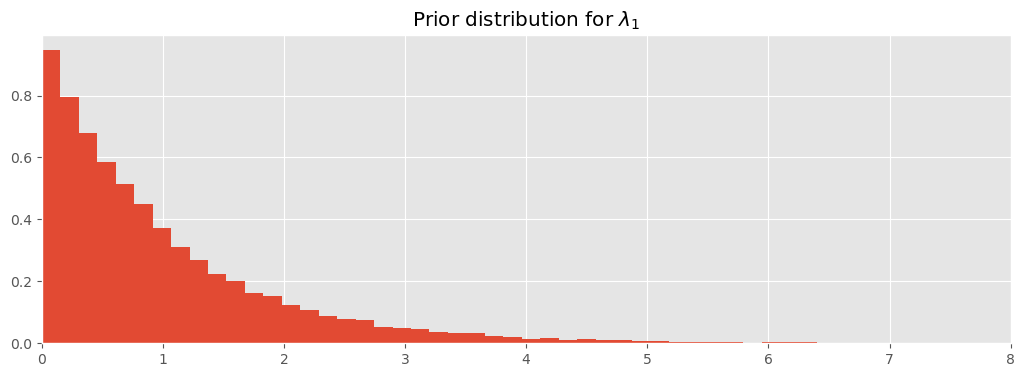

In [18]:
%matplotlib inline
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
import scipy.stats as stats
figsize(12.5, 4)
plt.style.use("ggplot")
samples = pm.draw(lambda_1, draws=20000)
plt.hist(samples, bins=70, density=True, histtype="stepfilled")
plt.title("Prior distribution for $\lambda_1$")
plt.xlim(0, 8);

We have specified $P(A)$. Our next goal is to include data/evidence/observations $X$ into our model. 

PyMC stochastic variables have a keyword argument `observed`. The keyword `observed` has a very simple role: fix the variable's current value to be the given data, typically a NumPy `array` or pandas `DataFrame`. For example:

In [19]:
data = np.array([10, 5])
with model:
    fixed_variable = pm.Poisson("fxd", 1, observed=data)
print(model.initial_point())

{'lambda_1_log__': array(-0.69314718), 'lambda_2_log__': array(-0.69314718), 'tau': array(5)}


This is how we include data into our models: initializing a stochastic variable to have a *fixed value*. 

To complete our text message example, we fix the PyMC variable `observations` to the observed dataset. 

In [24]:
# We're using some fake data here
data = np.array([10, 25, 15, 20, 35])
with model:
    obs = pm.Poisson("obs", lambda_, observed=data)
print(model.initial_point())

{'lambda_1_log__': array(-0.69314718), 'lambda_2_log__': array(-0.69314718), 'tau': array(5)}


## Modeling approaches

A good starting thought to Bayesian modeling is to think about *how your data might have been generated*. Position yourself in an omniscient position, and try to imagine how *you* would recreate the dataset. 

In the last chapter we investigated text message data. We begin by asking how our observations may have been generated:

1.  We started by thinking "what is the best random variable to describe this count data?" A Poisson random variable is a good candidate because it can represent count data. So we model the number of sms's received as sampled from a Poisson distribution.

2.  Next, we think, "Ok, assuming sms's are Poisson-distributed, what do I need for the Poisson distribution?" Well, the Poisson distribution has a parameter $\lambda$. 

3.  Do we know $\lambda$? No. In fact, we have a suspicion that there are *two* $\lambda$ values, one for the earlier behaviour and one for the later behaviour. We don't know when the behaviour switches though, but call the switchpoint $\tau$.

4. What is a good distribution for the two $\lambda$'s? The exponential is good, as it assigns probabilities to positive real numbers. Well the exponential distribution has a parameter too, call it $\alpha$.

5.  Do we know what the parameter $\alpha$ might be? No. At this point, we could continue and assign a distribution to $\alpha$, but it's better to stop once we reach a set level of ignorance: whereas we have a prior belief about $\lambda$, ("it probably changes over time", "it's likely between 10 and 30", etc.), we don't really have any strong beliefs about $\alpha$. So it's best to stop here. 

    What is a good value for $\alpha$ then? We think that the $\lambda$'s are between 10-30, so if we set $\alpha$ really low (which corresponds to larger probability on high values) we are not reflecting our prior well. Similar, a too-high alpha misses our prior belief as well. A good idea for $\alpha$ as to reflect our belief is to set the value so that the mean of $\lambda$, given $\alpha$, is equal to our observed mean. This was shown in the last chapter.

6. We have no expert opinion of when $\tau$ might have occurred. So we will suppose $\tau$ is from a discrete uniform distribution over the entire timespan.


Below we give a graphical visualization of this, where arrows denote `parent-child` relationships. (provided by the [Daft Python library](https://docs.daft-pgm.org/en/latest/) )

<img src="http://i.imgur.com/7J30oCG.png" width = 700/>


PyMC, and other probabilistic programming languages, have been designed to tell these data-generation *stories*. More generally, B. Cronin writes [5]:

> Probabilistic programming will unlock narrative explanations of data, one of the holy grails of business analytics and the unsung hero of scientific persuasion. People think in terms of stories - thus the unreasonable power of the anecdote to drive decision-making, well-founded or not. But existing analytics largely fails to provide this kind of story; instead, numbers seemingly appear out of thin air, with little of the causal context that humans prefer when weighing their options.

### Same story; different ending.

Interestingly, we can create *new datasets* by retelling the story.
For example, if we reverse the above steps, we can simulate a possible realization of the dataset.

1\. Specify when the user's behaviour switches by sampling from $\text{DiscreteUniform}(0, 80)$:

In [25]:
tau = np.random.randint(0, 80)
print(tau)

36


2\. Draw $\lambda_1$ and $\lambda_2$ from an $\text{Exp}(\alpha)$ distribution:

In [26]:
alpha = 1./20.
lambda_1, lambda_2 = np.random.exponential(scale=1/alpha, size=2)
print(lambda_1, lambda_2)

18.233146867864875 3.6535938156272207


3\.  For days before $\tau$, represent the user's received SMS count by sampling from $\text{Poi}(\lambda_1)$, and sample from  $\text{Poi}(\lambda_2)$ for days after $\tau$. For example:

In [27]:
data = np.r_[stats.poisson.rvs(mu=lambda_1, size=tau), stats.poisson.rvs(mu=lambda_2, size = 80 - tau)]

4\. Plot the artificial dataset:

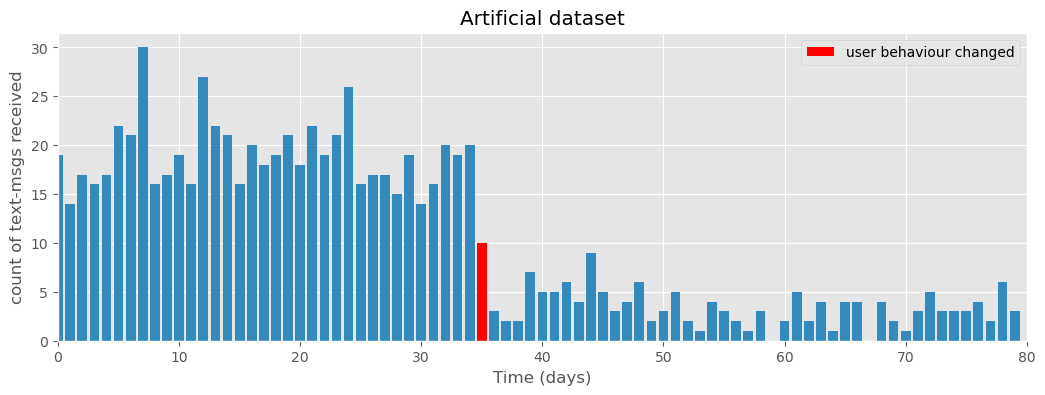

In [28]:
plt.bar(np.arange(80), data, color="#348ABD")
plt.bar(tau-1, data[tau - 1], color="r", label="user behaviour changed")
plt.xlabel("Time (days)")
plt.ylabel("count of text-msgs received")
plt.title("Artificial dataset")
plt.xlim(0, 80)
plt.legend();

It is okay that our fictional dataset does not look like our observed dataset: the probability is incredibly small it indeed would. PyMC's engine is designed to find good parameters, $\lambda_i, \tau$, that maximize this probability.  


The ability to generate artificial dataset is an interesting side effect of our modeling, and we will see that this ability is a very important method of Bayesian inference. We produce a few more datasets below:

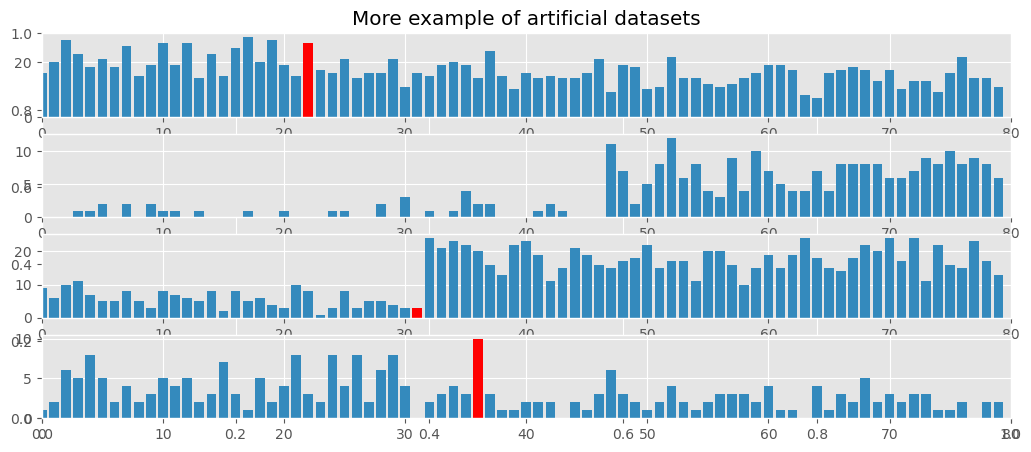

In [29]:
def plot_artificial_sms_dataset():
    tau = stats.randint.rvs(0, 80)
    alpha = 1./20.
    lambda_1, lambda_2 = stats.expon.rvs(scale=1/alpha, size=2)
    data = np.r_[stats.poisson.rvs(mu=lambda_1, size=tau), stats.poisson.rvs(mu=lambda_2, size=80 - tau)]
    plt.bar(np.arange(80), data, color="#348ABD")
    plt.bar(tau - 1, data[tau-1], color="r", label="user behaviour changed")
    plt.xlim(0, 80);

figsize(12.5, 5)
plt.title("More example of artificial datasets")
for i in range(4):
    plt.subplot(4, 1, i+1)
    plot_artificial_sms_dataset()


Later we will see how we use this to make predictions and test the appropriateness of our models.

## An algorithm for human deceit

Social data has an additional layer of interest as people are not always honest with responses, which adds a further complication into inference. For example, simply asking individuals "Have you ever cheated on a test?" will surely contain some rate of dishonesty. What you can say for certain is that the true rate is less than your observed rate (assuming individuals lie *only* about *not cheating*; I cannot imagine one who would admit "Yes" to cheating when in fact they hadn't cheated). 

To present an elegant solution to circumventing this dishonesty problem, and to demonstrate Bayesian modeling, we first need to introduce the binomial distribution.

### The Binomial Distribution

The binomial distribution is one of the most popular distributions, mostly because of its simplicity and usefulness.The binomial distribution has 2 parameters: $N$, a positive integer representing $N$ trials or number of instances of potential events, and $p$, the probability of an event occurring in a single trial. Like the Poisson distribution, it is a discrete distribution, but unlike the Poisson distribution, it only weighs integers from $0$ to $N$. The mass distribution looks like:

$$P( X = k ) =  {{N}\choose{k}}  p^k(1-p)^{N-k}$$

If $X$ is a binomial random variable with parameters $p$ and $N$, denoted $X \sim \text{Bin}(N,p)$, then $X$ is the number of events that occurred in the $N$ trials (obviously $0 \le X \le N$). The larger $p$ is (while still remaining between 0 and 1), the more events are likely to occur. The expected value of a binomial is equal to $Np$. Below we plot the mass probability distribution for varying parameters. 


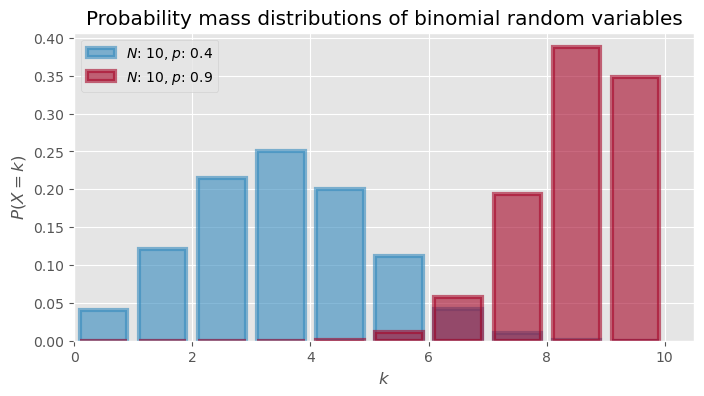

In [30]:
figsize(8, 4)

import scipy.stats as stats
binomial = stats.binom

parameters = [(10, .4), (10, .9)]
colors = ["#348ABD", "#A60628"]

for i in range(2):
    N, p = parameters[i]
    _x = np.arange(N + 1)
    plt.bar(_x - 0.5, binomial.pmf(_x, N, p), color=colors[i],
            edgecolor=colors[i],
            alpha=0.6,
            label="$N$: %d, $p$: %.1f" % (N, p),
            linewidth=3)

plt.legend(loc="upper left")
plt.xlim(0, 10.5)
plt.xlabel("$k$")
plt.ylabel("$P(X = k)$")
plt.title("Probability mass distributions of binomial random variables");

The special case when $N = 1$ corresponds to the Bernoulli distribution. There is another connection between Bernoulli and Binomial random variables. If we have $X_1, X_2, ... , X_N$ Bernoulli random variables with the same $p$, then $Z = X_1 + X_2 + ... + X_N \sim \text{Binomial}(N, p )$.

The expected value of a Bernoulli random variable is $p$. This can be seen by noting the more general Binomial random variable has expected value $Np$ and setting $N=1$.

##### Example: Cheating among students

We will use the binomial distribution to determine the frequency of students cheating during an exam. If we let $N$ be the total number of students who took the exam, and assuming each student is interviewed post-exam (answering without consequence), we will receive integer $X$ "Yes I did cheat" answers. We then find the posterior distribution of $p$, given $N$, some specified prior on $p$, and observed data $X$. 

This is a completely absurd model. No student, even with a free-pass against punishment, would admit to cheating. What we need is a better *algorithm* to ask students if they had cheated. Ideally the algorithm should encourage individuals to be honest while preserving privacy. The following proposed algorithm is a solution I greatly admire for its ingenuity and effectiveness:

> In the interview process for each student, the student flips a coin, hidden from the interviewer. The student agrees to answer honestly if the coin comes up heads. Otherwise, if the coin comes up tails, the student (secretly) flips the coin again, and answers "Yes, I did cheat" if the coin flip lands heads, and "No, I did not cheat", if the coin flip lands tails. This way, the interviewer does not know if a "Yes" was the result of a guilty plea, or a Heads on a second coin toss. Thus privacy is preserved and the researchers receive honest answers. 

I call this the Privacy Algorithm. One could of course argue that the interviewers are still receiving false data since some *Yes*'s are not confessions but instead randomness, but an alternative perspective is that the researchers are discarding approximately half of their original dataset since half of the responses will be noise. But they have gained a systematic data generation process that can be modeled. Furthermore, they do not have to incorporate (perhaps somewhat naively) the possibility of deceitful answers. We can use PyMC to dig through this noisy model, and find a posterior distribution for the true frequency of liars. 

Suppose 100 students are being surveyed for cheating, and we wish to find $p$, the proportion of cheaters. There are a few ways we can model this in PyMC.  In our data-generation model, we sample $p$, the true proportion of cheaters, from a prior. Since we are quite ignorant about $p$, we will assign it a $\text{Uniform}(0,1)$ prior.

In [32]:
import pymc as pm
N = 100
with pm.Model() as model:
    p = pm.Uniform("freq_cheating", 0, 1)

Again, thinking of our data-generation model, we assign Bernoulli random variables to the 100 students: 1 implies they cheated and 0 implies they did not. 

In [33]:
with model:
    true_answers = pm.Bernoulli("truths", p, shape=N, initval=np.random.binomial(1, 0.5, N))

If we carry out the algorithm, the next step that occurs is the first coin-flip each student makes. This can be modeled again by sampling 100 Bernoulli random variables with $p=1/2$: denote a 1 as a *Heads* and 0 a *Tails*.

In [34]:
with model:
    first_coin_flips = pm.Bernoulli("first_flips", 0.5, shape=N, initval=np.random.binomial(1, 0.5, N))
    
print(pm.draw(first_coin_flips))

[1 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 1 1 1 0 0 0 1 0 1 1
 1 1 0 0 1 0 0 1 0 0 1 1 0 0 0 0 0 0 0 1 1 0 1 1 0 0 1 1 0 0 0 0 1 1 1 1 1
 0 1 0 1 1 0 1 1 0 1 0 1 1 0 1 1 1 0 0 0 0 1 0 1 1 1]


Although *not everyone* flips a second time, we can still model the possible realization of second coin-flips:

In [35]:
with model:
    second_coin_flips = pm.Bernoulli("second_flips", 0.5, shape=N, initval=np.random.binomial(1, 0.5, N))

Using these variables, we can return a possible realization of the *observed proportion* of "Yes" responses. We do this using a PyMC `deterministic` variable:

In [36]:
import pytensor.tensor as at
with model:
    val = first_coin_flips*true_answers + (1 - first_coin_flips)*second_coin_flips
    observed_proportion = pm.Deterministic("observed_proportion", at.sum(val)/float(N))

The line `fc*t_a + (1-fc)*sc` contains the heart of the Privacy algorithm. Elements in this array are 1 *if and only if* i) the first toss is heads and the student cheated or ii) the first toss is tails, and the second is heads, and are 0 else. Finally, the last line sums this vector and divides by `float(N)`, produces a proportion. 

In [41]:
model.initial_point()

{'freq_cheating_interval__': array(0.),
 'truths': array([1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1,
        0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1,
        1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1,
        1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1,
        0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1]),
 'first_flips': array([1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0,
        1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0,
        0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0,
        0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1]),
 'second_flips': array([1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1,
        0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1,
        1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0,
        0, 1,

Next we need a dataset. After performing our coin-flipped interviews the researchers received 35 "Yes" responses. To put this into a relative perspective, if there truly were no cheaters, we should expect to see on average 1/4 of all responses being a "Yes" (half chance of having first coin land Tails, and another half chance of having second coin land Heads), so about 25 responses in a cheat-free world. On the other hand, if *all students cheated*, we should expected to see approximately 3/4 of all responses be "Yes". 

The researchers observe a Binomial random variable, with `N = 100` and `p = observed_proportion` with `value = 35`:  

In [42]:
X = 35

with model:
    observations = pm.Binomial("obs", N, observed_proportion, observed=X)

Below we add all the variables of interest to a `Model` container and run our black-box algorithm over the model. 

In [43]:

with model:
    step = pm.Metropolis(vars=[p])
    trace = pm.sample(40000, step=step,chains=1)
    # burned_trace = trace[15000:]
    

Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [freq_cheating]
>BinaryGibbsMetropolis: [truths, first_flips, second_flips]


Output()

Sampling 1 chain for 1_000 tune and 40_000 draw iterations (1_000 + 40_000 draws total) took 354 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


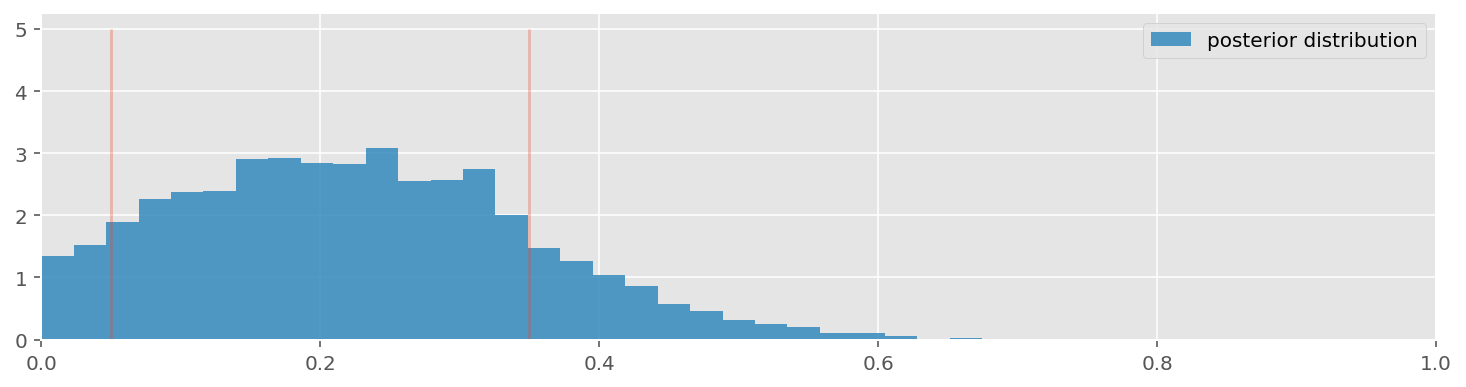

In [45]:
figsize(12.5, 3)
p_trace = np.concatenate(trace.posterior.freq_cheating.data[:,15000:]) #burned_trace["freq_cheating"][15000:]
plt.hist(p_trace, histtype="stepfilled", density=True, alpha=0.85, bins=30, 
         label="posterior distribution", color="#348ABD")
plt.vlines([.05, .35], [0, 0], [5, 5], alpha=0.3)
plt.xlim(0, 1)
plt.legend();

With regards to the above plot, we are still pretty uncertain about what the true frequency of cheaters might be, but we have narrowed it down to a range between 0.05 to 0.35 (marked by the solid lines). This is pretty good, as *a priori* we had no idea how many students might have cheated (hence the uniform distribution for our prior). On the other hand, it is also pretty bad since there is a .3 length window the true value most likely lives in. Have we even gained anything, or are we still too uncertain about the true frequency? 

I would argue, yes, we have discovered something. It is implausible, according to our posterior, that there are *no cheaters*, i.e. the posterior assigns low probability to $p=0$. Since we started with an uniform prior, treating all values of $p$ as equally plausible, but the data ruled out $p=0$ as a possibility, we can be confident that there were cheaters. 

This kind of algorithm can be used to gather private information from users and be *reasonably* confident that the data, though noisy, is truthful. 



### Alternative PyMC Model

Given a value for $p$ (which from our god-like position we know), we can find the probability the student will answer yes: 

\begin{align}
P(\text{"Yes"}) = & P( \text{Heads on first coin} )P( \text{cheater} ) + P( \text{Tails on first coin} )P( \text{Heads on second coin} ) \\\\
& = \frac{1}{2}p + \frac{1}{2}\frac{1}{2}\\\\
& = \frac{p}{2} + \frac{1}{4}
\end{align}

Thus, knowing $p$ we know the probability a student will respond "Yes". In PyMC, we can create a deterministic function to evaluate the probability of responding "Yes", given $p$:

In [46]:
with pm.Model() as model:
    p = pm.Uniform("freq_cheating", 0, 1)
    p_skewed = pm.Deterministic("p_skewed", 0.5*p + 0.25)

I could have typed `p_skewed  = 0.5*p + 0.25` instead for a one-liner, as the elementary operations of addition and scalar multiplication will implicitly create a `deterministic` variable, but I wanted to make the deterministic boilerplate explicit for clarity's sake. 

If we know the probability of respondents saying "Yes", which is `p_skewed`, and we have $N=100$ students, the number of "Yes" responses is a binomial random variable with parameters `N` and `p_skewed`.

This is where we include our observed 35 "Yes" responses. In the declaration of the `pm.Binomial`, we include `value = 35` and `observed = True`.

In [47]:
with model:
    yes_responses = pm.Binomial("number_cheaters", 100, p_skewed, observed=35)

Below we add all the variables of interest to a `Model` container and run our black-box algorithm over the model. 

In [48]:
with model:
    # To Be Explained in Chapter 3!
    step = pm.Metropolis()
    # the new kwarg tune means drop the first 2500 unstable data
    trace = pm.sample(25000, step=step,tune=2500)
    # burned_trace = trace[2500:]

Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [freq_cheating]


Sampling 4 chains for 1_000 tune and 25_000 draw iterations (4_000 + 100_000 draws total) took 5 seconds.


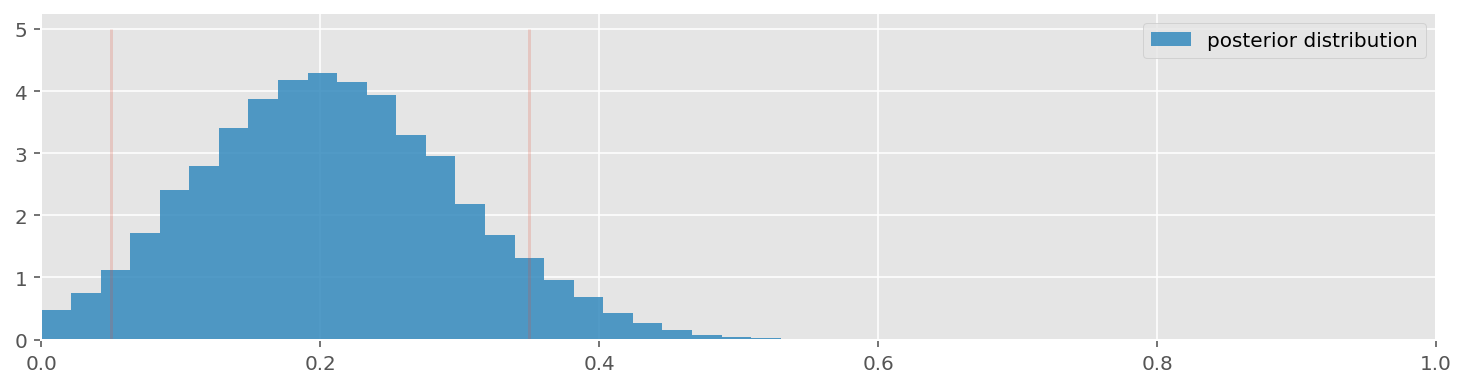

In [49]:
figsize(12.5, 3)
p_trace = np.concatenate(trace.posterior.freq_cheating.data[:,:])# burned_trace["freq_cheating"]
plt.hist(p_trace, histtype="stepfilled", density=True, alpha=0.85, bins=30, 
         label="posterior distribution", color="#348ABD")
plt.vlines([.05, .35], [0, 0], [5, 5], alpha=0.2)
plt.xlim(0, 1)
plt.legend();

### More PyMC Tricks

#### Protip: Arrays of PyMC variables
There is no reason why we cannot store multiple heterogeneous PyMC variables in a Numpy array. Just remember to set the `dtype` of the array to `object` upon initialization. For example:




In [50]:
N = 10
x = np.ones(N, dtype=object)
with pm.Model() as model:
    for i in range(0, N):
        x[i] = pm.Exponential('x_%i' % i, (i+1.0)**2)

##### Exercises

1\. Try putting in extreme values for our observations in the cheating example. What happens if we observe 25 affirmative responses? 10? 50? 

2\. Try plotting $\alpha$ samples versus $\beta$ samples.  Why might the resulting plot look like this?

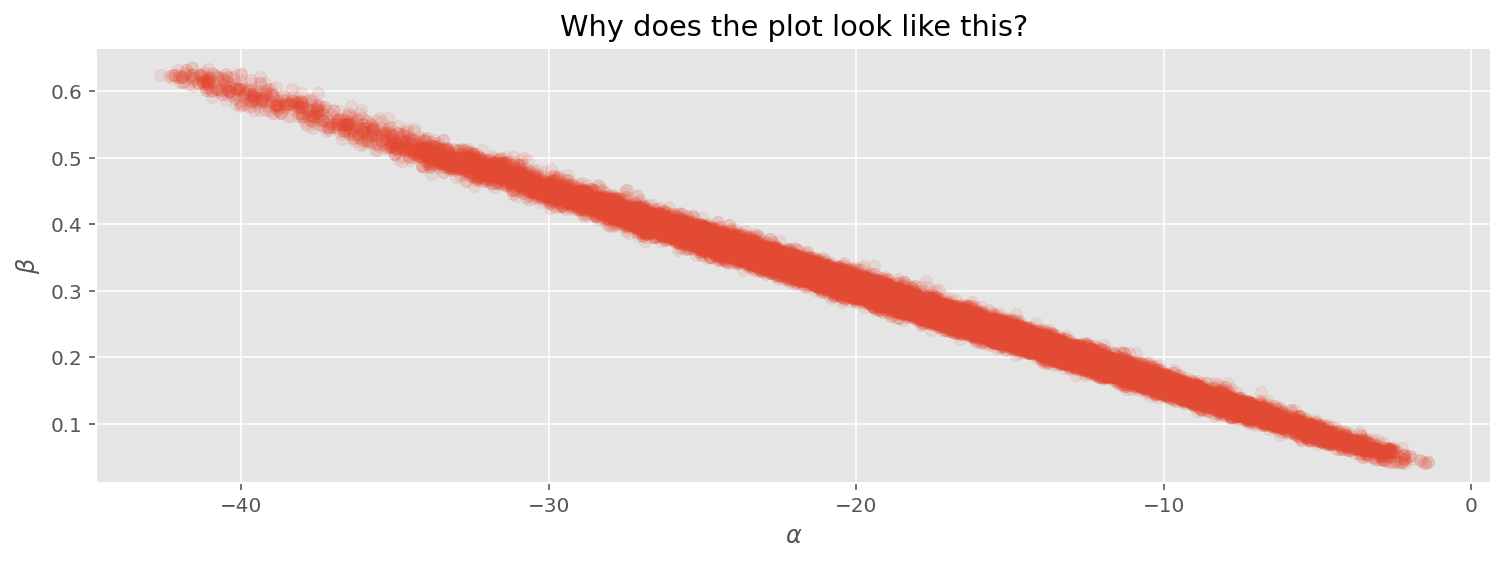

In [69]:
#type your code here.
figsize(12.5, 4)

plt.scatter(alpha_samples, beta_samples, alpha=0.1)
plt.title("Why does the plot look like this?")
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\beta$");

### References

-  [1] Dalal, Fowlkes and Hoadley (1989),JASA, 84, 945-957.
-  [2] German Rodriguez. Datasets. In WWS509. Retrieved 30/01/2013, from <http://data.princeton.edu/wws509/datasets/#smoking>.
-  [3] McLeish, Don, and Cyntha Struthers. STATISTICS 450/850 Estimation and Hypothesis Testing. Winter 2012. Waterloo, Ontario: 2012. Print.
-  [4] Fonnesbeck, Christopher. "Building Models." PyMC-Devs. N.p., n.d. Web. 26 Feb 2013. <http://pymc-devs.github.com/pymc/modelbuilding.html>.
- [5] Cronin, Beau. "Why Probabilistic Programming Matters." 24 Mar 2013. Google, Online Posting to Google . Web. 24 Mar. 2013. <https://plus.google.com/u/0/107971134877020469960/posts/KpeRdJKR6Z1>.
- [6] S.P. Brooks, E.A. Catchpole, and B.J.T. Morgan. Bayesian animal survival estimation. Statistical Science, 15: 357–376, 2000
- [7] Gelman, Andrew. "Philosophy and the practice of Bayesian statistics." British Journal of Mathematical and Statistical Psychology. (2012): n. page. Web. 2 Apr. 2013.
- [8] Greenhill, Brian, Michael D. Ward, and Audrey Sacks. "The Separation Plot: A New Visual Method for Evaluating the Fit of Binary Models." American Journal of Political Science. 55.No.4 (2011): n. page. Web. 2 Apr. 2013.

In [70]:
from IPython.core.display import HTML


def css_styling():
    styles = open("../styles/custom.css", "r").read()
    return HTML(styles)
css_styling()